<a href="https://colab.research.google.com/github/TruscaPetre/AAIT-Nosy-Missing-Labels/blob/main/tutorial%20colab%20noisy%20labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Noisy labels problem


## Introduction theory

Before starting to implement anything we should think about the problem first. We don't know which of the training samples are wrong, and we cannot try to correct them by hand because there are too many of them and the images are not very clear anyway.

We need some Noise-aware training techniques. Some ideas are:
- training using a loss function that is designed to be robust to label noise. Such as:
  - focal loss, it down-weighs the contribution of easy examples and puts more ephasis on difficult examples, which can make it resistant to noise. `torch.nn.FocalLoss`
  - Generalized Cross-Entropy loss, which includes additional hyperparameters that allow the model to learn the noise rate and label corruption matrix. `torch.nn.GCE`
- bootstrapping
- self-ensembling to learn multiple models that are more robust to noise
- Confidence based method, because predicting the confidence may allow humans to discard the least confidence examples. ( but we are not creating a real world model, we are getting tested automatically with a test set, so this method cannot work.)
- Pseudo-labeling, using the model's own predictions to re-label a portion of the training data. Similar to self-training, we eliminate completely labels of some samples and we try to predict them. In case the labels are the same after relabling, there is a higher chance they are correct. We would gradually relable the images into a better dataset. 
    - Or Computing a probability that the labels are misslabeled, than using that probability to weigh heavier on the labels that have a higher chance of being correct during training. `torch.nn.CrossEntropyLoss`
- Noise tolerant algorithms: complex deep learning models are more tolerant to noise. (this is not a very solid technique but should be used together with others.)

References:
- Focal loss: This loss function was first introduced in the paper "Focal Loss for Dense Object Detection" by Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He, and Piotr Dollár (https://arxiv.org/abs/1708.02002).
- Generalized cross-entropy loss: This loss function was proposed in the paper "Learning with Noisy Labels" by Mengye Ren, Elad Hazan, and Yoram Singer (https://arxiv.org/abs/1609.03683).
- Bootstrapping: This technique involves training multiple models on different subsets of the training data, and then combining their predictions to make a final prediction. It was first introduced in the paper "Bagging Predictors" by Leo Breiman (https://link.springer.com/article/10.1023/A:1018054314350).
- Self-ensembling: This technique involves training multiple models on the same data, and then using their predictions to create a final prediction. It was first introduced in the paper "Self-Ensembling for Visual Domain Adaptation" by Sergey Zagoruyko and Nikos Komodakis (https://arxiv.org/abs/1706.05208).
- Pseudo-labeling: This technique involves using the model's own predictions to label a portion of the training data. It was first introduced in the paper "Semi-Supervised Learning with Deep Generative Models" by Diederik Kingma, Danilo Jimenez Rezende, Shakir Mohamed, and Max Welling (https://arxiv.org/abs/1406.5298).
- Noise-aware training: This refers to techniques that are specifically designed to handle label noise in the training data. One example of such a technique is the generalized cross-entropy loss function, which was introduced in the paper "Learning with Noisy Labels" by Mengye Ren, Elad Hazan, and Yoram Singer (https://arxiv.org/abs/1609.03683).
- Confidence based methods: This refers to techniques that involve training a model to predict the confidence or probability of each class label, rather than just the class label itself. This can allow the model to identify examples that are less confident and potentially more prone to noise. One example of a confidence-based method is the method of "bootstrapping," which was introduced in the paper "Bagging Predictors" by Leo Breiman (https://link.springer.com/article/10.1023/A:1018054314350).

## Pseudo Labeling solution


This technique is barely described above

The first question is what portion of the dataset should I "forget" the labels and try predict new ones(by training on the remaining ones)? 

Making the worse assumption that half of the labels are wrong. Than we should leave out a smaller portion of the labels to be re-labeled.
But because we have a rather large dataset of 500 images per class and that the model we are using is a rather complex one which is already pretrained, we may increase the number of labels for re-labeling. 

According to previous argument I chose to separate the dataset in 10 parts. 
I will leave 10% of the dataset out and only use the rest of 90%. 
Similar to a 10-fold cross validation, but instead of validating we are re-labeling the remaining 10% of the data.

## Imports

In [2]:
import urllib
import shutil
import os
import time
import copy
import json

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader
from torchvision import transforms, datasets 

from sklearn.metrics import classification_report

import itertools
     

In [3]:
task2_id = "1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL" 

In [4]:
# replace here your ide &id=1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL"
# replace here your id 'https://docs.google.com/uc?export=download&id=1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL'
# replace here your target name -O task1.tar.gz &&
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL" -O task2.tar.gz && rm -rf /tmp/cookies.txt


--2022-12-31 13:47:10--  https://docs.google.com/uc?export=download&confirm=t&id=1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL
Resolving docs.google.com (docs.google.com)... 74.125.24.100, 74.125.24.102, 74.125.24.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hpf1s7iefa506dfesahfhq54i3jfcceg/1672494375000/08997952672865575084/*/1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL?e=download&uuid=d022b4db-2461-4b44-9673-dce9b63509c3 [following]
--2022-12-31 13:47:11--  https://doc-04-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hpf1s7iefa506dfesahfhq54i3jfcceg/1672494375000/08997952672865575084/*/1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL?e=download&uuid=d022b4db-2461-4b44-9673-dce9b63509c3
Resolving doc-04-8k-docs.googleusercontent.com (doc-04-8k-docs.googleusercontent.com)... 172.253.118.132, 240

In [5]:
%%capture
!mkdir data
!mv task2.tar.gz ./data
!tar -xzvf "/content/data/task2.tar.gz" -C "/content/data/"     #[run this cell to extract tar.gz files]
# this may take 12 seconds

In [6]:
experiment_info = {
    "iteration": 1,
    "image_processing":{
        "resize":224,
        "mean":[0.485, 0.456, 0.406],
        "std":[0.229, 0.224, 0.225],
    },
    "hyperparameters_data": {
        "batch_size":32,
        "shuffle_dataloader":True,
        "num_workers":4
    },
    "random_seeds":{
        "torch_seed":42,
        "numpy_seed":42,
        "cuda_seed":42,

    },
    "hyperparameters_training":{
        "learning_rate": 0.0001,
        "scheduler_step_size":7,
        "scheduler_gamma":0.1,
        "num_epochs":10, 
    },
    "total_unlabeled":26445,
}
     

## Mount drive 
( in order to save each iteration of leave out labels)

In [7]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [8]:
with open('/gdrive/MyDrive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/MyDrive/foo.txt'

Hello Google Drive!

In [9]:
!rm '/gdrive/MyDrive/foo.txt'

## Seting up things

In [10]:
# Set up seeds for reproducibility
np.random.seed(experiment_info["random_seeds"]["numpy_seed"])
torch.manual_seed(experiment_info["random_seeds"]["torch_seed"])
torch.cuda.manual_seed_all(experiment_info["random_seeds"]["cuda_seed"])

In [11]:
dir_data = 'data/task2/train_data/'
# Read the annotations file into a DataFrame
df = pd.read_csv(f'{dir_data}annotations.csv')

In [12]:
df

,renamed_path,label_idx
0,task2/train_data/images/labeled/0.jpeg,0
1,task2/train_data/images/labeled/1.jpeg,0
2,task2/train_data/images/labeled/2.jpeg,0
3,task2/train_data/images/labeled/3.jpeg,0
4,task2/train_data/images/labeled/4.jpeg,0
...,...,...
49995,task2/train_data/images/labeled/49995.jpeg,5
49996,task2/train_data/images/labeled/49996.jpeg,94
49997,task2/train_data/images/labeled/49997.jpeg,24
49998,task2/train_data/images/labeled/49998.jpeg,85


In [26]:
# Define the base directory

base_dir = 'data/task2/train_data/images'
# Check if the directory exists, to recreate it instead of messing it up
target_dir = 'data/task2/images_by_class'

if os.path.exists(target_dir):
    # Use rmtree to delete the directory and all its contents
    shutil.rmtree(target_dir)
    print(f'{target_dir} has been deleted')
else:
    print(f'{target_dir} does not exist')

# Iterate over the rows in the DataFrame
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Extract the path and class from the row
    path = row['renamed_path']
    label = row['label_idx']
    
    # Create the directory for the class
    class_dir = f'{target_dir}/{label}'
    os.makedirs(class_dir, exist_ok=True)
    
    # Copy the file to the class directory
    shutil.copy(f"data/{path}", class_dir) 

data/task2/images_by_class has been deleted


100%|██████████| 50000/50000 [00:11<00:00, 4343.12it/s]


## Create datset splits for pseudo-labeling

In [27]:
preprocess = transforms.Compose([
    transforms.Resize(experiment_info["image_processing"]["resize"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=experiment_info["image_processing"]["mean"],
                         std=experiment_info["image_processing"]["std"]),
    ])

In [28]:
class ShuffledImageFolder(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = torch.randperm(len(dataset))

    def __getitem__(self, index):
        path, _ = self.dataset.samples[self.indices[index]]
        image, label = self.dataset[self.indices[index]]
        return image, label, path

    def __len__(self):
        return len(self.dataset)

data_dir = 'data/task2/images_by_class'
image_dataset_unshuffled = datasets.ImageFolder(data_dir, preprocess)
image_dataset = ShuffledImageFolder(image_dataset_unshuffled)

In [30]:
num_samples = len(image_dataset)

# Split the image_dataset into 10 parts
part_size = num_samples // 10
parts = [list(range(i * part_size, (i + 1) * part_size)) for i in range(10)]

batch_size = experiment_info["hyperparameters_data"]["batch_size"]
# Use one part for creating new labels and the other 9 parts for training the model
loaders = {}
for i in range(10):
    # Get the indices for the training set, which are not in the labeling set
    train_indices = [index for j, part in enumerate(parts) if j != i for index in part]
    labeling_indices = parts[i]

    # Create a sampler for the training set and the labeling set
    train_sampler = SubsetRandomSampler(train_indices)
    labeling_sampler = SubsetRandomSampler(labeling_indices)

    # Use the samplers to create data loaders for the training set and the labeling set
    train_loader = DataLoader(image_dataset, batch_size=batch_size, sampler=train_sampler)
    labeling_loader = DataLoader(image_dataset, batch_size=batch_size, sampler=labeling_sampler)
    loaders[i] = {
        "train":train_loader, 
        "labeling":labeling_loader
    }

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_sizes = {
    "train" : len(loaders[0]["train"]), # this is the number of batches not images
    "labeling" : len(loaders[0]["labeling"]),
}

### sanity check
See how many labels are in each training set
Visualize the distribution of labels

In [31]:

print(len(loaders[0]["train"])*batch_size)
print(len(loaders[0]["labeling"])*batch_size)


45024
5024


In [32]:
# sanity check, verify the distribution of labels in training and labeling sets
labels_for_distribution = [label_batch for _,label_batch,_ in tqdm(loaders[0]["train"])]

100%|██████████| 1407/1407 [01:23<00:00, 16.77it/s]


In [33]:
labels_distrib = torch.cat(labels_for_distribution)

Text(0.5, 1.0, 'Distribution of Labels')

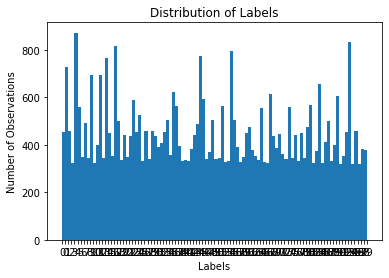

In [34]:
counts, bins, patches = plt.hist(labels_distrib, bins = 100)

# Set x-axis label
plt.xlabel('Labels')
plt.xticks(bins, bins.astype(int))
# Set y-axis label
plt.ylabel('Number of Observations')

# Set plot title
plt.title('Distribution of Labels')  

## Train on the remaining data 

In [35]:
# Download a pytorch MobileNet pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# change the Linear output to fit our dataset ( because model initially has 1000 classes)
model.classifier[1] = nn.Linear(1280, 100)
# Setting hyperparameters

model = model.to(device)
print(model.classifier)
     

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


In [36]:
def train_loop(model, scheduler, optimizer, criterion, dataset_size, dataloader):
                     
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels, _ in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
    
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    return model, epoch_loss, epoch_acc

def train_model(model, *args, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()  # Set model to training mode
        model, epoch_loss, epoch_acc = train_loop(model, *args)
        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [37]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(
    model.parameters(),
    lr=experiment_info["hyperparameters_training"]["learning_rate"],
    )

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size=experiment_info["hyperparameters_training"]["scheduler_step_size"], 
    gamma=experiment_info["hyperparameters_training"]["scheduler_gamma"],
    )
     

In [ ]:
model = train_model(model, 
                    exp_lr_scheduler, 
                    optimizer, 
                    criterion,  
                    data_sizes["train"], 
                    loaders[0]["train"], 
                    num_epochs=experiment_info["hyperparameters_training"]["num_epochs"])

Epoch 0/9
----------


100%|██████████| 1407/1407 [04:26<00:00,  5.29it/s]


Loss: 72.5423 Acc: 13.7484

Epoch 1/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 45.0769 Acc: 19.0071

Epoch 2/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 36.1820 Acc: 20.9026

Epoch 3/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.47it/s]


Loss: 29.3312 Acc: 22.5622

Epoch 4/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]


Loss: 23.8855 Acc: 24.1471

Epoch 5/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.49it/s]


Loss: 19.0713 Acc: 25.5572

Epoch 6/9
----------


 82%|████████▏ | 1147/1407 [03:28<00:47,  5.43it/s]

In [ ]:
# Save the model
torch.save(model.state_dict(), '/gdrive/MyDrive/checkpoints/noisy_labels/model_it_0.pt')

In [ ]:
predicted_labels = {
    "path":[],
    "confidence":[],
    "label":[]
}

# Each epoch has a training and validation phase 
model.eval()   # Set model to evaluate mode 

# Iterate over data.
for inputs, _, path in tqdm(loaders[0]["train"]):
    inputs = inputs.to(device)

    # forward
    with torch.set_grad_enabled(False): # we don't want to train
        outputs = model(inputs)
        confidence, preds = torch.max(outputs, 1) 
    predicted_labels["path"].append(path) 
    predicted_labels["confidence"].append(confidence.item())
    predicted_labels["label"].append(preds.item())



In [ ]:
# Load the experiment information from the JSON file
num_iteration = 0
# Save the experiment information to a JSON file
with open(f'/gdrive/MyDrive/checkpoints/iteration_{num_iteration}_images.json', 'w') as f:
    json.dump(predicted_labels, f)

In [ ]:
# Repeat process for the other iterations

In [ ]:
# TODO:  save each iteration labels preferably a dataframe into a csv
# TODO, during the training, for each iteration, 
# add a new set of labels to the csv that tells us the annotations

In [ ]:
# TODO: at the end of the training phase
# use the predictions made by the models 
# to choose the images with the highest confidence
# by selecting the images that consistently have the same label
# this set of images will become an always used 
# set in the next training phase, it should not be forgetten again
# because there is a high confidence that these labels have the 
# correct labels 
# because I have leave 9 out technique,
# I will have 9 labels for each image
# and also the original label.
# the probability that those labels are correct can be 
# simply counting the label that occurs most often
# than dividing that number by 10